In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

In [2]:
df = pd.read_csv('Validation error of 400 images')
df.head()

,Unnamed: 0,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
0,0,0.0,0.000015,-3.978928,1.332155e-14,2.725203,4.461775,-7.797309,1.518400e+27,1000.000778,...,4.044774e-19,3.918385e-19,4.378870e-19,1.518400e+27,1000.000441,4.114950e-19,55928800.0,4.131994e-19,4.139853e-19,4.074418e-19
1,0,0.0,-0.000011,-1.145825,0.000000e+00,7.348629,4.142889,11.112458,1.518400e+27,1000.000778,...,4.044774e-19,3.918385e-19,4.378870e-19,1.518400e+27,1000.000441,4.114950e-19,55928800.0,4.131994e-19,4.139853e-19,4.074418e-19
2,0,0.0,-0.000018,-0.779943,-1.332155e-14,4.309702,7.899474,-0.181957,1.518400e+27,1000.000778,...,4.044774e-19,3.918385e-19,4.378870e-19,1.518400e+27,1000.000441,4.114950e-19,55928800.0,4.131994e-19,4.139853e-19,4.074418e-19
3,0,0.0,0.000035,8.873287,0.000000e+00,-0.466937,11.161376,-4.931220,1.518400e+27,1000.000778,...,4.044774e-19,3.918385e-19,4.378870e-19,1.518400e+27,1000.000441,4.114950e-19,55928800.0,4.131994e-19,4.139853e-19,4.074418e-19
4,0,0.0,0.000051,12.883820,-1.332155e-14,4.639861,1.462184,-1.215558,1.518400e+27,1000.000778,...,4.044774e-19,3.918385e-19,4.378870e-19,1.518400e+27,1000.000441,4.114950e-19,55928800.0,4.131994e-19,4.139853e-19,4.074418e-19


In [3]:
df.describe()

,Unnamed: 0,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
count,400.0,400.0,400.000000,400.000000,4.000000e+02,400.000000,400.000000,400.000000,4.000000e+02,4.000000e+02,...,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,400.0,4.000000e+02,4.000000e+02,4.000000e+02
mean,0.0,0.0,0.000004,2.584057,4.462718e-15,3.225486,3.751601,2.228265,1.518400e+27,1.000001e+03,...,4.044774e-19,3.918385e-19,4.378870e-19,1.518400e+27,1.000000e+03,4.114950e-19,55928800.0,4.131994e-19,4.139853e-19,4.074418e-19
std,0.0,0.0,0.000034,4.895157,1.094040e-14,4.384294,4.413279,5.053856,5.504443e+12,2.731901e-12,...,3.085347e-33,2.121176e-33,1.542674e-33,5.504443e+12,3.073389e-12,6.267111e-34,0.0,1.687299e-33,3.374598e-33,2.265802e-33
min,0.0,0.0,-0.000071,-6.416842,-1.332155e-14,-4.731871,-4.161559,-7.797309,1.518400e+27,1.000001e+03,...,4.044774e-19,3.918385e-19,4.378870e-19,1.518400e+27,1.000000e+03,4.114950e-19,55928800.0,4.131994e-19,4.139853e-19,4.074418e-19
25%,0.0,0.0,-0.000024,-1.534044,0.000000e+00,-0.331998,0.121555,-1.771561,1.518400e+27,1.000001e+03,...,4.044774e-19,3.918385e-19,4.378870e-19,1.518400e+27,1.000000e+03,4.114950e-19,55928800.0,4.131994e-19,4.139853e-19,4.074418e-19
50%,0.0,0.0,0.000004,2.286604,0.000000e+00,2.815034,3.784815,2.265462,1.518400e+27,1.000001e+03,...,4.044774e-19,3.918385e-19,4.378870e-19,1.518400e+27,1.000000e+03,4.114950e-19,55928800.0,4.131994e-19,4.139853e-19,4.074418e-19
75%,0.0,0.0,0.000032,6.847715,1.332155e-14,6.661051,7.388492,6.046939,1.518400e+27,1.000001e+03,...,4.044774e-19,3.918385e-19,4.378870e-19,1.518400e+27,1.000000e+03,4.114950e-19,55928800.0,4.131994e-19,4.139853e-19,4.074418e-19
max,0.0,0.0,0.000080,14.729569,2.664309e-14,13.821367,13.412825,14.269908,1.518400e+27,1.000001e+03,...,4.044774e-19,3.918385e-19,4.378870e-19,1.518400e+27,1.000000e+03,4.114950e-19,55928800.0,4.131994e-19,4.139853e-19,4.074418e-19


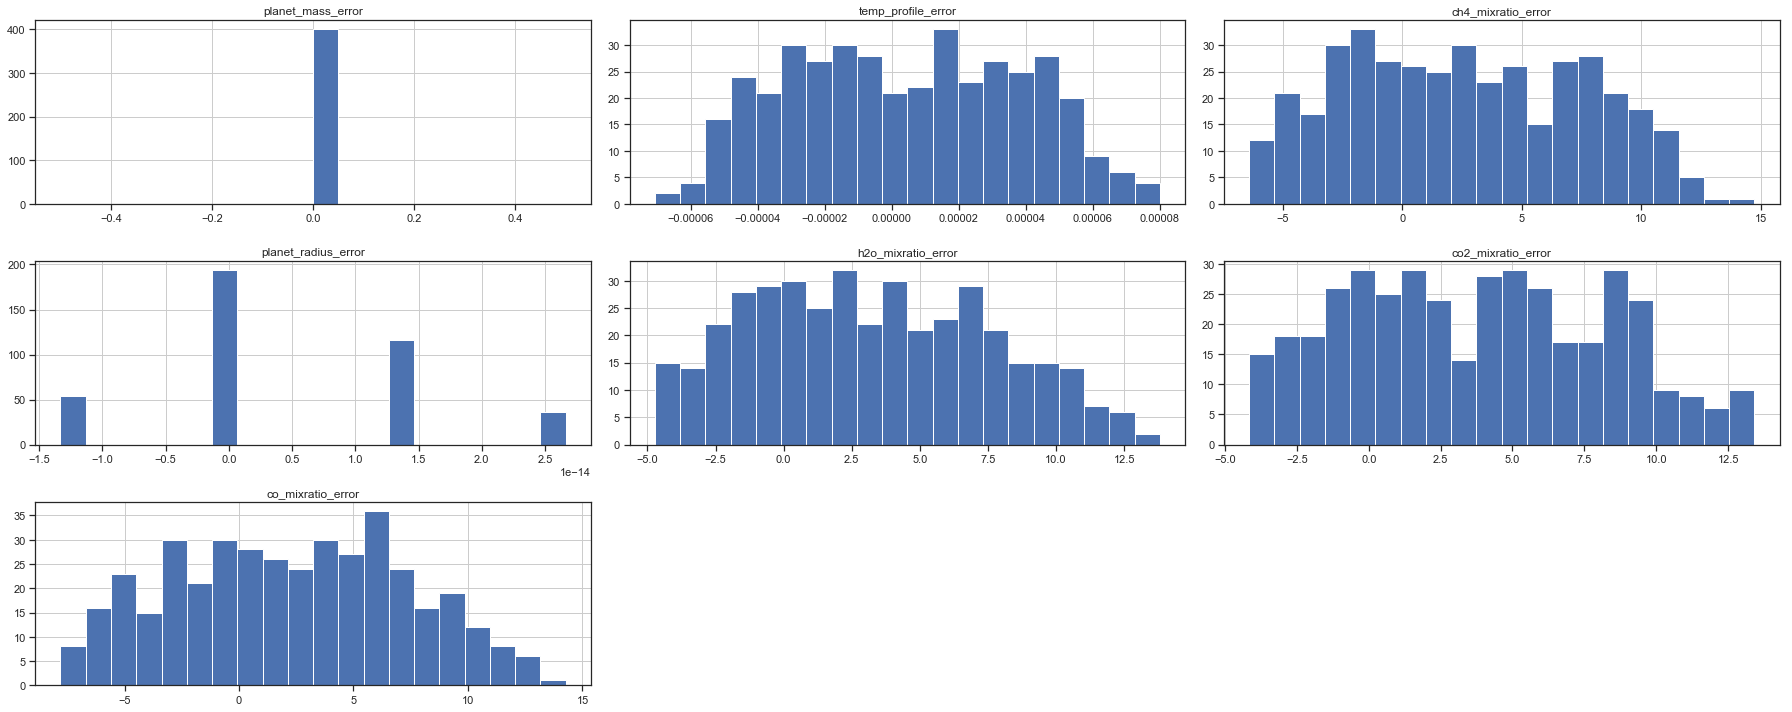

In [6]:
params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error')
    plt.hist(df[param+'_error'], bins=20)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

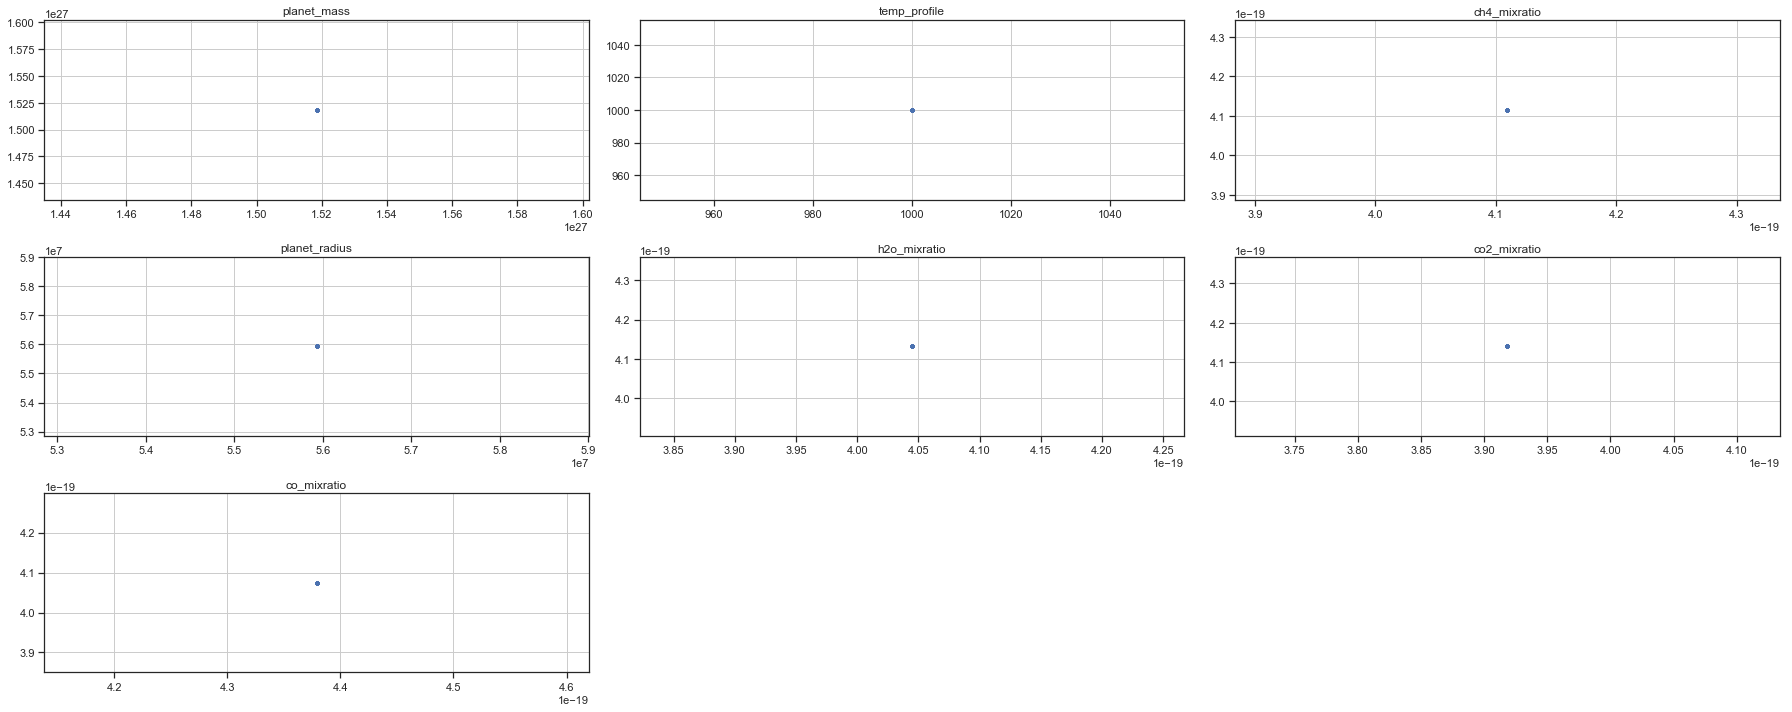

In [37]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param)
    plt.plot(df[param+'_real'], df[param+'_inpainted'], '.')
    plt.grid()
    plt.tight_layout()

Looks like the NN only outputs one value... Which by analysing the images isn't the case. So the decoding is wrong